<a href="https://colab.research.google.com/github/Charliongithub/DM2024-Lab2-Homework/blob/main/Another_copy_of_notebook32747db4f1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install Kaggle API
!pip install kaggle

# Upload your Kaggle API key (kaggle.json)
from google.colab import files
files.upload()  # Choose your kaggle.json file

# Move kaggle.json to the correct location
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [ ]:
# Download the dataset
!kaggle competitions download -c dm-2024-isa-5810-lab-2-homework

# Verify the download
import os
print("Files in current directory:", os.listdir('.'))


dm-2024-isa-5810-lab-2-homework.zip: Skipping, found more recently modified local copy (use --force to force download)
Files in current directory: ['.config', 'dm-2024-isa-5810-lab-2-homework', 'dm-2024-isa-5810-lab-2-homework.zip', 'sample_data']


In [ ]:
import zipfile

# Extract the ZIP file
with zipfile.ZipFile('dm-2024-isa-5810-lab-2-homework.zip', 'r') as zip_ref:
    zip_ref.extractall('dm-2024-isa-5810-lab-2-homework')

# Verify extracted files
print("Files in extracted folder:", os.listdir('dm-2024-isa-5810-lab-2-homework'))


Files in extracted folder: ['tweets_DM.json', 'emotion.csv', 'data_identification.csv', 'sampleSubmission.csv']


In [ ]:
#Set up
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score

In [ ]:
#Load the data

# Load the data_identification.csv file
data_identification = pd.read_csv('dm-2024-isa-5810-lab-2-homework/data_identification.csv')
print("Data Identification Head:")
print(data_identification.head())

# Load the emotion.csv file
emotion = pd.read_csv('dm-2024-isa-5810-lab-2-homework/emotion.csv')
print("\nEmotion Data Head:")
print(emotion.head())

# Load the tweets_DM.json file
tweets = []  # List to store extracted data

with open('dm-2024-isa-5810-lab-2-homework/tweets_DM.json', 'r') as f:
    for line in f:
        data = json.loads(line.strip())  # Parse each line as JSON
        tweet_id = data["_source"]["tweet"]["tweet_id"]  # Extract tweet_id
        text = data["_source"]["tweet"]["text"]  # Extract tweet text
        tweets.append({"tweet_id": tweet_id, "text": text})  # Append to list

# Convert tweets list to a DataFrame
tweets_df = pd.DataFrame(tweets)
print("\nTweets DataFrame Head:")
print(tweets_df.head())


Data Identification Head:
   tweet_id identification
0  0x28cc61           test
1  0x29e452          train
2  0x2b3819          train
3  0x2db41f           test
4  0x2a2acc          train

Emotion Data Head:
   tweet_id       emotion
0  0x3140b1       sadness
1  0x368b73       disgust
2  0x296183  anticipation
3  0x2bd6e1           joy
4  0x2ee1dd  anticipation

Tweets DataFrame Head:
   tweet_id                                               text
0  0x376b20  People who post "add me on #Snapchat" must be ...
1  0x2d5350  @brianklaas As we see, Trump is dangerous to #...
2  0x28b412  Confident of your obedience, I write to you, k...
3  0x1cd5b0                Now ISSA is stalking Tasha 😂😂😂 <LH>
4  0x2de201  "Trust is not the same as faith. A friend is s...


In [ ]:
print(data_identification.isnull().sum())

tweet_id          0
identification    0
dtype: int64


In [ ]:
print(data_identification.head())

   tweet_id identification
0  0x28cc61           test
1  0x29e452          train
2  0x2b3819          train
3  0x2db41f           test
4  0x2a2acc          train


In [ ]:
print(data_identification.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1867535 entries, 0 to 1867534
Data columns (total 2 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   tweet_id        object
 1   identification  object
dtypes: object(2)
memory usage: 28.5+ MB
None


In [ ]:
print(f"Number of duplicate tweet_id: {data_identification['tweet_id'].duplicated().sum()}")

Number of duplicate tweet_id: 0


In [ ]:
print(f"Number of missing tweet_id: {emotion['tweet_id'].isnull().sum()}")
print(f"Number of duplicate tweet_id: {emotion['tweet_id'].duplicated().sum()}")

Number of missing tweet_id: 0
Number of duplicate tweet_id: 0


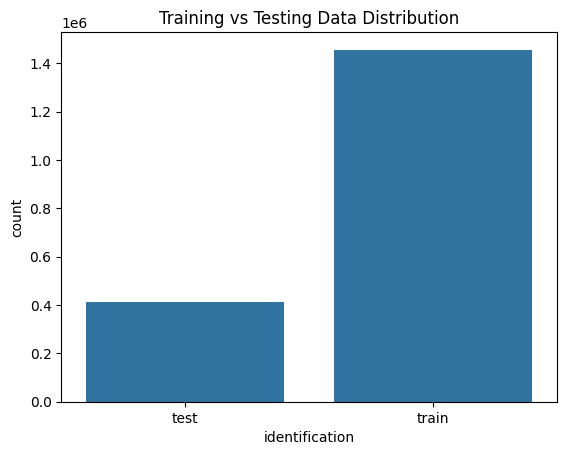

In [ ]:
#Check the distribution
sns.countplot(data=data_identification, x='identification')
plt.title("Training vs Testing Data Distribution")
plt.show()

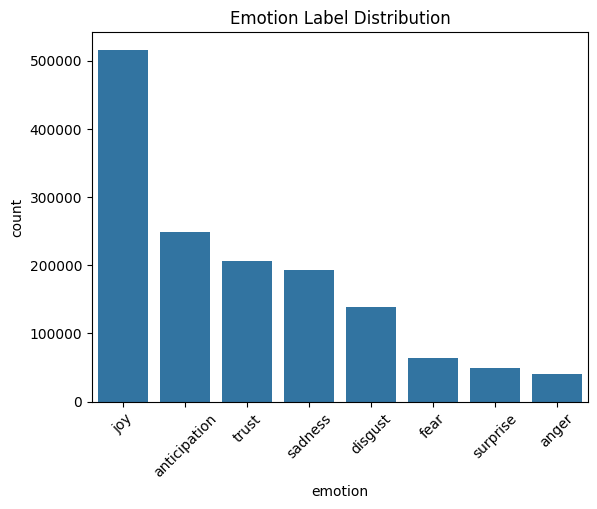

In [ ]:
#Check the distribution
sns.countplot(data=emotion, x='emotion', order=emotion['emotion'].value_counts().index)
plt.title("Emotion Label Distribution")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Combine data_identification.csv and tweets_DM.json
tweets_df = pd.DataFrame(tweets)
merged_data = pd.merge(data_identification, tweets_df, on='tweet_id', how='left')  # Merge using tweet_id

print(merged_data.head())

   tweet_id identification                                               text
0  0x28cc61           test  @Habbo I've seen two separate colours of the e...
1  0x29e452          train  Huge Respect🖒 @JohnnyVegasReal talking about l...
2  0x2b3819          train  Yoooo we hit all our monthly goals with the ne...
3  0x2db41f           test  @FoxNews @KellyannePolls No serious self respe...
4  0x2a2acc          train  @KIDSNTS @PICU_BCH @uhbcomms @BWCHBoss Well do...


In [ ]:
#Add emotion labels to training data
train_data = pd.merge(merged_data[merged_data['identification'] == 'train'], emotion, on='tweet_id', how='left')
test_data = merged_data[merged_data['identification'] == 'test']

In [ ]:
print(train_data.head())
print(test_data.head())

   tweet_id identification                                               text  \
0  0x29e452          train  Huge Respect🖒 @JohnnyVegasReal talking about l...   
1  0x2b3819          train  Yoooo we hit all our monthly goals with the ne...   
2  0x2a2acc          train  @KIDSNTS @PICU_BCH @uhbcomms @BWCHBoss Well do...   
3  0x2a8830          train  Come join @ambushman27 on #PUBG while he striv...   
4  0x20b21d          train  @fanshixieen2014 Blessings!My #strength little...   

        emotion  
0           joy  
1           joy  
2         trust  
3           joy  
4  anticipation  
    tweet_id identification                                               text
0   0x28cc61           test  @Habbo I've seen two separate colours of the e...
3   0x2db41f           test  @FoxNews @KellyannePolls No serious self respe...
15  0x2466f6           test  Looking for a new car, and it says 1 lady owne...
23  0x23f9e9           test  @cineworld “only the brave” just out and fount...
31  0x1fb4

In [ ]:
#Text Preprocessing
import nltk

# Download the stopwords corpus
nltk.download('stopwords')

# Verify that stopwords are available
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
print("Stopwords loaded successfully!")


Stopwords loaded successfully!


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import nltk
import re
from nltk.corpus import stopwords

# Download NLTK stopwords
nltk.download('stopwords')

# Load stopwords
stop_words = set(stopwords.words('english'))

# Define the text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+|#\w+', '', text)  # Remove mentions and hashtags
    text = re.sub(r'<lh>', '', text)  # Remove <LH> placeholders
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return ' '.join(words)

# Apply the cleaning function to the text column
train_data['cleaned_text'] = train_data['text'].apply(clean_text)
test_data['cleaned_text'] = test_data['text'].apply(clean_text)

print("Preprocessing complete!")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Preprocessing complete!


<ipython-input-19-ac9ff2be105f>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['cleaned_text'] = test_data['text'].apply(clean_text)


In [ ]:
train_data = train_data.copy()
test_data = test_data.copy()

train_data.loc[:, 'cleaned_text'] = train_data['text'].apply(clean_text)
test_data.loc[:, 'cleaned_text'] = test_data['text'].apply(clean_text)

In [ ]:
print(train_data[['text', 'cleaned_text']].head())
print(test_data[['text', 'cleaned_text']].head())

                                                text  \
0  Huge Respect🖒 @JohnnyVegasReal talking about l...   
1  Yoooo we hit all our monthly goals with the ne...   
2  @KIDSNTS @PICU_BCH @uhbcomms @BWCHBoss Well do...   
3  Come join @ambushman27 on #PUBG while he striv...   
4  @fanshixieen2014 Blessings!My #strength little...   

                                        cleaned_text  
0  huge respect talking losing dad cancerif dont ...  
1          yoooo hit monthly goals new app two weeks  
2                           well done team every one  
3                  come join strives chicken donners  
4  blessingsmy little brittledoor open wont go no...  
                                                 text  \
0   @Habbo I've seen two separate colours of the e...   
3   @FoxNews @KellyannePolls No serious self respe...   
15  Looking for a new car, and it says 1 lady owne...   
23  @cineworld “only the brave” just out and fount...   
31  Felt like total dog 💩 going into open gym an

In [ ]:
#Most frequent label is "joy," while "anger" is the least frequent.
#This imbalance could affect model training and evaluation.

from sklearn.utils import resample

# Get the majority class
majority = train_data[train_data['emotion'] == 'joy']

# Set a target size for oversampling
target_size = int(len(majority) * 0.75)  # 75% of the majority class size

balanced_data = [majority]

for emotion in train_data['emotion'].unique():
    if emotion != 'joy':
        minority = train_data[train_data['emotion'] == emotion]
        oversampled_minority = resample(minority,
                                        replace=True,
                                        n_samples=min(target_size, len(majority)),  # Cap size
                                        random_state=42)
        balanced_data.append(oversampled_minority)

train_data_balanced = pd.concat(balanced_data)

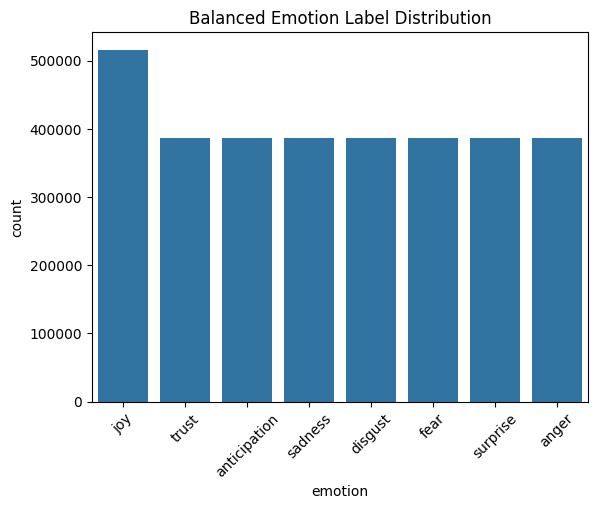

In [ ]:
# Check new label distribution
sns.countplot(data=train_data_balanced, x='emotion', order=train_data_balanced['emotion'].value_counts().index)
plt.title("Balanced Emotion Label Distribution")
plt.xticks(rotation=45)
plt.show()

In [ ]:
#try use SMOTE for synthetic data
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from collections import Counter

# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=500, ngram_range=(1, 1), max_df=0.8, min_df=5)
X_train = vectorizer.fit_transform(train_data['cleaned_text'])
y_train = train_data['emotion']

In [ ]:
# Inspect the shape of the feature matrix
print("TF-IDF matrix shape:", X_train.shape)

TF-IDF matrix shape: (1455563, 500)


In [ ]:
# Subset a smaller portion of the dataset for testing becasue of computional limitation
train_sample = train_data_balanced.sample(frac=0.2, random_state=42)
X_sample = vectorizer.transform(train_sample['cleaned_text'])
y_sample = train_sample['emotion']

# Apply SMOTE on the subset
smote = SMOTE(random_state=42)
X_sample_smote, y_sample_smote = smote.fit_resample(X_sample, y_sample)

print("Subset SMOTE label distribution:", Counter(y_sample_smote))


Subset SMOTE label distribution: Counter({'trust': 103169, 'fear': 103169, 'surprise': 103169, 'joy': 103169, 'sadness': 103169, 'anticipation': 103169, 'disgust': 103169, 'anger': 103169})


In [ ]:
print("Shape of resampled data:", X_sample_smote.shape)
print("First 5 resampled labels:", y_sample_smote[:5])


Shape of resampled data: (825352, 500)
First 5 resampled labels: 0       trust
1        fear
2    surprise
3         joy
4         joy
Name: emotion, dtype: object


In [ ]:
#Split the balanced subset into training and validation sets
from sklearn.model_selection import train_test_split

# Split data
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_sample_smote, y_sample_smote, test_size=0.2, random_state=42
)

print("Training set shape:", X_train_split.shape)
print("Validation set shape:", X_val.shape)


Training set shape: (660281, 500)
Validation set shape: (165071, 500)


In [ ]:
#Train the baseline logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score

# Train Logistic Regression
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_split, y_train_split)

# Predict on validation set
y_val_pred = model.predict(X_val)

In [ ]:
print(classification_report(y_val, y_val_pred))
print("Macro F1 Score:", f1_score(y_val, y_val_pred, average='macro'))

              precision    recall  f1-score   support

       anger       0.26      0.30      0.28     20784
anticipation       0.37      0.39      0.38     20720
     disgust       0.24      0.20      0.22     20650
        fear       0.35      0.34      0.34     20429
         joy       0.33      0.23      0.27     20765
     sadness       0.27      0.19      0.23     20468
    surprise       0.20      0.33      0.25     20619
       trust       0.32      0.30      0.31     20636

    accuracy                           0.29    165071
   macro avg       0.29      0.29      0.29    165071
weighted avg       0.29      0.29      0.29    165071

Macro F1 Score: 0.2854374060325052


In [ ]:
#optimize parameters to capture more meaningful features
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=2000, ngram_range=(1, 2), max_df=0.9, min_df=5)
X_train = vectorizer.fit_transform(train_data_balanced['cleaned_text'])
X_val = vectorizer.transform(test_data['cleaned_text'])

print("TF-IDF matrix shape:", X_train.shape)


TF-IDF matrix shape: (3225101, 2000)


In [ ]:
# Logistic regression with class weights
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
from sklearn.utils.class_weight import compute_class_weight

classes = train_data_balanced['emotion'].unique()
class_weights = compute_class_weight('balanced', classes=classes, y=train_data_balanced['emotion'])
class_weights_dict = dict(zip(classes, class_weights))
print("Class Weights:", class_weights_dict)

Class Weights: {'joy': 0.7812487282395735, 'trust': 1.0416669896540676, 'anticipation': 1.0416669896540676, 'sadness': 1.0416669896540676, 'disgust': 1.0416669896540676, 'fear': 1.0416669896540676, 'surprise': 1.0416669896540676, 'anger': 1.0416669896540676}


In [ ]:
# Split training and validation sets
from sklearn.model_selection import train_test_split
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, train_data_balanced['emotion'], test_size=0.2, random_state=42)

In [ ]:
# Train Logistic Regression
model = LogisticRegression(max_iter=1000, class_weight=class_weights_dict, random_state=42)
model.fit(X_train_split, y_train_split)

LogisticRegression(class_weight={'anger': 1.0416669896540676,
                                 'anticipation': 1.0416669896540676,
                                 'disgust': 1.0416669896540676,
                                 'fear': 1.0416669896540676,
                                 'joy': 0.7812487282395735,
                                 'sadness': 1.0416669896540676,
                                 'surprise': 1.0416669896540676,
                                 'trust': 1.0416669896540676},
                   max_iter=1000, random_state=42)

In [ ]:
y_val_pred = model.predict(X_val_split)
print(classification_report(y_val_split, y_val_pred))
print("Macro F1 Score:", f1_score(y_val_split, y_val_pred, average='macro'))

              precision    recall  f1-score   support

       anger       0.37      0.44      0.40     77448
anticipation       0.41      0.46      0.43     77113
     disgust       0.29      0.30      0.29     77404
        fear       0.35      0.48      0.41     77500
         joy       0.41      0.31      0.35    103170
     sadness       0.31      0.24      0.27     77646
    surprise       0.34      0.30      0.32     77264
       trust       0.35      0.34      0.34     77476

    accuracy                           0.36    645021
   macro avg       0.35      0.36      0.35    645021
weighted avg       0.36      0.36      0.35    645021

Macro F1 Score: 0.35261323642016495


In [ ]:
test_data['cleaned_text'] = test_data['text'].apply(clean_text)

# Transform test data into feature matrix using the same TF-IDF vectorizer
X_test = vectorizer.transform(test_data['cleaned_text'])

In [ ]:
# Predict emotions for the test set
y_test_pred = model.predict(X_test)
print("Test predictions:", y_test_pred[:5])  # Print the first 5 predictions

Test predictions: ['surprise' 'fear' 'joy' 'disgust' 'disgust']


#SAVE CSV

In [ ]:
# Save predictions to CSV
submission = pd.DataFrame({
    'id': test_data['tweet_id'],
    'emotion': y_test_pred
})

submission.to_csv('112zm1031v1.csv', index=False)
print("Submission file created: 112zm1031v1.csv")


#Save Intermediate Results

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_data_balanced.to_csv('/content/drive/My Drive/train_data_balanced.csv', index=False)
test_data.to_csv('/content/drive/My Drive/test_data.csv', index=False)

import joblib
joblib.dump(vectorizer, '/content/drive/My Drive/tfidf_vectorizer.pkl')
joblib.dump(model, '/content/drive/My Drive/logistic_regression_model.pkl')


['/content/drive/My Drive/logistic_regression_model.pkl']

#Reload Intermediate Results

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Load files from Drive
train_data_balanced = pd.read_csv('/content/drive/My Drive/train_data_balanced.csv')
test_data = pd.read_csv('/content/drive/My Drive/test_data.csv')

vectorizer = joblib.load('/content/drive/My Drive/tfidf_vectorizer.pkl')
model = joblib.load('/content/drive/My Drive/logistic_regression_model.pkl')

print("Files loaded successfully!")


#Enhance Preprocessing

In [ ]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

def enhanced_clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+|#\w+', '', text)  # Remove mentions and hashtags
    text = re.sub(r'<lh>', '', text)  # Remove <LH> placeholders
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    words = [lemmatizer.lemmatize(word) for word in words]  # Lemmatize words
    return ' '.join(words)

# Apply the enhanced cleaning function
train_data['cleaned_text'] = train_data['text'].apply(enhanced_clean_text)
test_data['cleaned_text'] = test_data['text'].apply(enhanced_clean_text)

print("Enhanced Preprocessing complete!")


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Enhanced Preprocessing complete!


In [ ]:
from textblob import TextBlob

# Add tweet length and number of hashtags as features
train_data['text_length'] = train_data['text'].apply(len)
train_data['num_hashtags'] = train_data['text'].apply(lambda x: x.count('#'))

# Add sentiment polarity as a feature
train_data['sentiment'] = train_data['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Repeat for test data
test_data['text_length'] = test_data['text'].apply(len)
test_data['num_hashtags'] = test_data['text'].apply(lambda x: x.count('#'))
test_data['sentiment'] = test_data['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

print("Custom features added!")


Custom features added!


In [ ]:
 #Inspect the Processed Data
print("Missing values in training data:")
print(train_data.isnull().sum())
print("\nMissing values in test data:")
print(test_data.isnull().sum())


Missing values in training data:
tweet_id          0
identification    0
text              0
emotion           0
cleaned_text      0
text_length       0
num_hashtags      0
sentiment         0
dtype: int64

Missing values in test data:
tweet_id          0
identification    0
text              0
cleaned_text      0
text_length       0
num_hashtags      0
sentiment         0
dtype: int64


In [ ]:
print("\nTraining Data Feature Summary:")
print(train_data[['text_length', 'num_hashtags', 'sentiment']].describe())


Training Data Feature Summary:
        text_length  num_hashtags     sentiment
count  1.455563e+06  1.455563e+06  1.455563e+06
mean   8.817590e+01  1.153890e+00  1.168474e-01
std    3.492589e+01  1.576503e+00  3.305844e-01
min    9.000000e+00  0.000000e+00 -1.000000e+00
25%    5.900000e+01  0.000000e+00  0.000000e+00
50%    9.100000e+01  1.000000e+00  0.000000e+00
75%    1.200000e+02  2.000000e+00  2.875000e-01
max    2.020000e+02  8.500000e+01  1.000000e+00


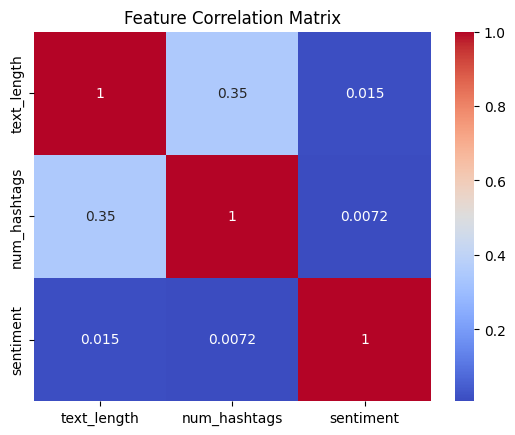

In [ ]:
#Check Correlation Between Features:
#Ensure that text_length, num_hashtags, and sentiment are not highly correlated, as this could lead to redundancy.
correlation_matrix = train_data[['text_length', 'num_hashtags', 'sentiment']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()


In [ ]:
#Combine Features for Training
# Recalculate additional features for the balanced dataset
train_data_balanced['text_length'] = train_data_balanced['text'].apply(len)
train_data_balanced['num_hashtags'] = train_data_balanced['text'].apply(lambda x: x.count('#'))
train_data_balanced['sentiment'] = train_data_balanced['text'].apply(lambda x: TextBlob(x).sentiment.polarity)


In [ ]:
# Extract additional features from the balanced dataset
additional_features_train = train_data_balanced[['text_length', 'num_hashtags', 'sentiment']].values
additional_features_test = test_data[['text_length', 'num_hashtags', 'sentiment']].values


In [ ]:
from scipy.sparse import hstack

# Combine the aligned TF-IDF features with additional features
X_train_combined = hstack([X_train, additional_features_train])
X_test_combined = hstack([X_test, additional_features_test])

print("Training set shape with combined features:", X_train_combined.shape)
print("Test set shape with combined features:", X_test_combined.shape)


Training set shape with combined features: (3225101, 2003)
Test set shape with combined features: (411972, 2003)


In [ ]:
from scipy.sparse import hstack

# Vectorize the text column for the balanced training data
X_train_tfidf = vectorizer.fit_transform(train_data_balanced['cleaned_text'])

# Extract additional features for training data
additional_features_train = train_data_balanced[['text_length', 'num_hashtags', 'sentiment']].values

# Combine TF-IDF features and additional features
X_train_combined = hstack([X_train_tfidf, additional_features_train])

print("X_train_combined shape:", X_train_combined.shape)  # Should match y_train
print("y_train shape:", y_train.shape)


X_train_combined shape: (3225101, 2003)
y_train shape: (1455563,)


In [ ]:
y_train = train_data_balanced['emotion']
print("Updated y_train shape:", y_train.shape)  # Should now match X_train_combined's rows


Updated y_train shape: (3225101,)


In [ ]:
assert X_train_combined.shape[0] == y_train.shape[0], "Mismatch between X_train_combined and y_train"
print("X_train_combined and y_train are aligned!")


X_train_combined and y_train are aligned!


In [ ]:
from sklearn.model_selection import train_test_split

# Split data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_combined, y_train, test_size=0.2, random_state=42
)

print("Training set shape:", X_train_split.shape)
print("Validation set shape:", X_val_split.shape)


Training set shape: (2580080, 2003)
Validation set shape: (645021, 2003)


#Speeding Up Training

In [ ]:
sample_percentage = 0.2
sample_indices = np.random.choice(X_train_split.shape[0], int(X_train_split.shape[0] * sample_percentage), replace=False)
X_train_sample = X_train_split[sample_indices]
y_train_sample = y_train_split.iloc[sample_indices]

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

In [ ]:
sample_percentage = 0.1
sample_indices = np.random.choice(X_train_split.shape[0], int(X_train_split.shape[0] * sample_percentage), replace=False)
X_train_sample = X_train_split[sample_indices]
y_train_sample = y_train_split.iloc[sample_indices]
rf_model.fit(X_train_sample, y_train_sample)


RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=50,
                       n_jobs=-1, random_state=42)

#Train the model finally

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score

# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf_model.fit(X_train_split, y_train_split)

# Evaluate on the validation set
y_val_pred_rf = rf_model.predict(X_val_split)
print(classification_report(y_val_split, y_val_pred_rf))
print("Random Forest Macro F1 Score:", f1_score(y_val_split, y_val_pred_rf, average='macro'))


              precision    recall  f1-score   support

       anger       0.76      0.12      0.21     77448
anticipation       0.42      0.27      0.33     77113
     disgust       0.21      0.31      0.25     77404
        fear       0.25      0.52      0.34     77500
         joy       0.50      0.16      0.24    103170
     sadness       0.22      0.18      0.20     77646
    surprise       0.63      0.11      0.18     77264
       trust       0.19      0.48      0.27     77476

    accuracy                           0.26    645021
   macro avg       0.40      0.27      0.25    645021
weighted avg       0.40      0.26      0.25    645021

Random Forest Macro F1 Score: 0.2519801154233674


In [ ]:
from joblib import dump

dump(rf_model, "random_forest_model.pkl")
dump(X_train_combined, "X_train_combined.pkl")
dump(y_train, "y_train.pkl")
print("Model and features saved!")


Model and features saved!


In [ ]:
from scipy.sparse import vstack
import numpy as np

# Convert to CSR format for indexing
X_train_combined_csr = X_train_combined.tocsr()

# Increase sample size to 30% of the training data
sample_percentage = 0.3  # Adjust this as needed
sample_size = int(X_train_combined_csr.shape[0] * sample_percentage)

# Generate valid sample indices
np.random.seed(42)  # For reproducibility
sample_indices = np.random.choice(np.arange(X_train_combined_csr.shape[0]), sample_size, replace=False)

# Efficiently slice using CSR format
X_train_split = X_train_combined_csr[sample_indices]
y_train_split = y_train.iloc[sample_indices].reset_index(drop=True)

# Verify shapes
print("X_train_split shape:", X_train_split.shape)
print("y_train_split shape:", y_train_split.shape)


X_train_split shape: (967530, 2003)
y_train_split shape: (967530,)


In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=200,  # Increase trees
    max_depth=20,  # Allow deeper trees
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf_model.fit(X_train_split, y_train_split)

RandomForestClassifier(class_weight='balanced', max_depth=20, n_estimators=200,
                       n_jobs=-1, random_state=42)

In [ ]:
# Evaluate on the validation set
from sklearn.metrics import classification_report, f1_score

# Predict on validation data
y_val_pred_rf = rf_model.predict(X_val_split)

# Print classification report
print("Validation Classification Report:")
print(classification_report(y_val_split, y_val_pred_rf))

# Calculate and print Macro F1 Score
macro_f1 = f1_score(y_val_split, y_val_pred_rf, average='macro')
print(f"Random Forest Macro F1 Score: {macro_f1:.4f}")


Validation Classification Report:
              precision    recall  f1-score   support

       anger       0.64      0.20      0.30     77448
anticipation       0.54      0.28      0.37     77113
     disgust       0.20      0.49      0.28     77404
        fear       0.28      0.51      0.36     77500
         joy       0.50      0.21      0.30    103170
     sadness       0.25      0.19      0.22     77646
    surprise       0.41      0.16      0.23     77264
       trust       0.27      0.39      0.32     77476

    accuracy                           0.30    645021
   macro avg       0.39      0.30      0.30    645021
weighted avg       0.39      0.30      0.30    645021

Random Forest Macro F1 Score: 0.2979


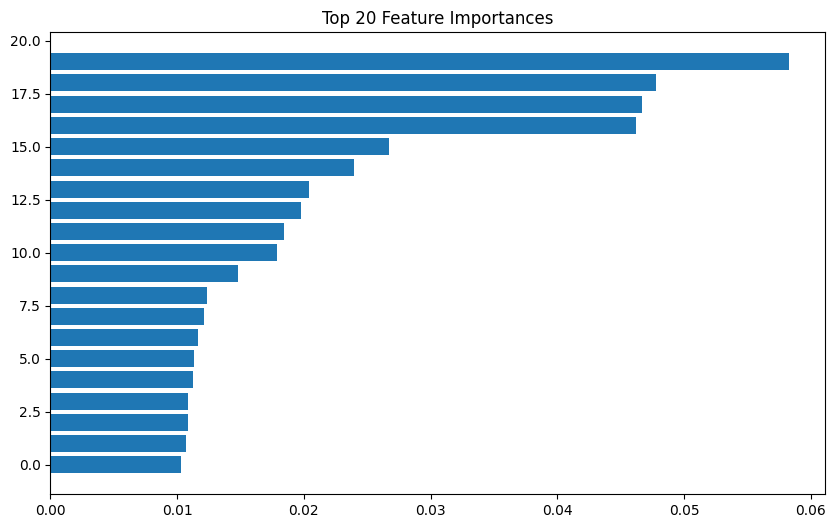

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances
feature_importances = rf_model.feature_importances_

# Plot the top 20 most important features
plt.figure(figsize=(10, 6))
indices = np.argsort(feature_importances)[-20:]  # Top 20 features
plt.barh(range(len(indices)), feature_importances[indices], align='center')
plt.title("Top 20 Feature Importances")
plt.show()


In [ ]:
#Reduce the Training Data Size for Tuning
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Subset the training data
sample_percentage = 0.2  # 20% of the training data
sample_size = int(X_train_split.shape[0] * sample_percentage)
sample_indices = np.random.choice(X_train_split.shape[0], sample_size, replace=False)

X_train_sample = X_train_split[sample_indices]
y_train_sample = y_train_split.iloc[sample_indices].reset_index(drop=True)

# Define a reduced parameter distribution
param_dist = {
    'n_estimators': [100, 150],  # Smaller range
    'max_depth': [10, 20],       # Smaller range
    'min_samples_split': [5, 10],  # Prioritize practical values
    'min_samples_leaf': [1, 2],
}

# Initialize Random Forest with balanced class weights
rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,  # Fewer iterations
    cv=3,       # Cross-validation folds
    scoring='f1_macro',
    verbose=2,
    random_state=42,
    n_jobs=-1,
)

# Fit RandomizedSearchCV on the subset
random_search.fit(X_train_sample, y_train_sample)

# Best parameters
print("Best parameters:", random_search.best_params_)

# Use the best model for evaluation
best_rf_model = random_search.best_estimator_


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 20}


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score

# Train Random Forest with best parameters
final_rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=1,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Train on the full training dataset
final_rf_model.fit(X_train_split, y_train_split)

# Evaluate on validation data
y_val_pred_rf = final_rf_model.predict(X_val_split)
print("Validation Classification Report:")
print(classification_report(y_val_split, y_val_pred_rf))
print("Random Forest Macro F1 Score (Validation):", f1_score(y_val_split, y_val_pred_rf, average='macro'))


Validation Classification Report:
              precision    recall  f1-score   support

       anger       0.60      0.20      0.30     77448
anticipation       0.53      0.28      0.37     77113
     disgust       0.19      0.47      0.28     77404
        fear       0.29      0.50      0.37     77500
         joy       0.49      0.21      0.30    103170
     sadness       0.24      0.21      0.22     77646
    surprise       0.36      0.18      0.24     77264
       trust       0.27      0.37      0.31     77476

    accuracy                           0.30    645021
   macro avg       0.37      0.30      0.30    645021
weighted avg       0.38      0.30      0.30    645021

Random Forest Macro F1 Score (Validation): 0.29793698814047753


In [ ]:
#LightGBM Approach
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, f1_score

# Train LightGBM Classifier
lgb_model = LGBMClassifier(
    n_estimators=200,
    max_depth=20,
    learning_rate=0.05,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
lgb_model.fit(X_train_split, y_train_split)

# Evaluate
y_val_pred_lgb = lgb_model.predict(X_val_split)
print("Validation Classification Report:")
print(classification_report(y_val_split, y_val_pred_lgb))
print("LightGBM Macro F1 Score (Validation):", f1_score(y_val_split, y_val_pred_lgb, average='macro'))


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.600616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191775
[LightGBM] [Info] Number of data points in the train set: 967530, number of used features: 2003
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
Validation Classification Report:
              precision    recall  f1-score   support

       anger       0.42      0.44      0.43     77448
anticipation       0.46      0.43      0.45     77113
     disgust       0.28      0.39      0.32     77404
        fear       0.41

In [ ]:
# Save predictions to CSV
submission = pd.DataFrame({
    'id': test_data['tweet_id'],
    'emotion': lgb_model.predict(X_test_combined)
})

submission.to_csv('112zm1031v2.csv', index=False)
print("Submission file created: 112zm1031v2.csv")

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")


Submission file created: 112zm1031v2.csv


#SAVE

In [ ]:
# Save Intermediate Results

from google.colab import drive
drive.mount('/content/drive')

# Save balanced training data
train_data_balanced.to_csv('/content/drive/My Drive/train_data_balanced_v2.csv', index=False)
test_data.to_csv('/content/drive/My Drive/test_data_v2.csv', index=False)

# Save vectorizer
import joblib
joblib.dump(vectorizer, '/content/drive/My Drive/tfidf_vectorizer_v2.pkl')

# Save combined features and labels
from scipy.sparse import save_npz
save_npz('/content/drive/My Drive/X_train_combined_v2.npz', X_train_combined)
save_npz('/content/drive/My Drive/X_test_combined_v2.npz', X_test_combined)

y_train.to_csv('/content/drive/My Drive/y_train_v2.csv', index=False)

# Save the trained LightGBM model
joblib.dump(lgb_model, '/content/drive/My Drive/lightgbm_model_v2.pkl')

print("Process saved successfully!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Process saved successfully!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import joblib
from scipy.sparse import save_npz

# Save balanced training data and test data
train_data_balanced.to_csv('/content/drive/My Drive/train_data_balanced_v2.csv', index=False)
test_data.to_csv('/content/drive/My Drive/test_data_v2.csv', index=False)

# Save vectorizer (TF-IDF)
joblib.dump(vectorizer, '/content/drive/My Drive/tfidf_vectorizer_v2.pkl')

# Save combined features and labels
save_npz('/content/drive/My Drive/X_train_combined_v2.npz', X_train_combined)
save_npz('/content/drive/My Drive/X_test_combined_v2.npz', X_test_combined)

# Save labels for training data
y_train.to_csv('/content/drive/My Drive/y_train_v2.csv', index=False)

# Save the trained LightGBM model
joblib.dump(lgb_model, '/content/drive/My Drive/lightgbm_model_v2.pkl')

# Save Random Forest model (if applicable)
joblib.dump(rf_model, '/content/drive/My Drive/random_forest_model_v2.pkl')

# Save any other model if needed (e.g., Logistic Regression)
joblib.dump(model, '/content/drive/My Drive/logistic_regression_model_v2.pkl')

print("All items have been saved successfully!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
All items have been saved successfully!


#OpenAI API


In [ ]:
import openai
import numpy as np

# Set your OpenAI API key
openai.api_key = 'KEY'

In [ ]:
def classify_texts_using_gpt(texts, labels):
    responses = []
    for text in texts:
        # Create a better, more specific prompt
        prompt = (
            f"I want you to classify the following text into one of these emotions: {', '.join(labels)}. "
            "Take into account the context and sentiment. Please provide only the most likely label.\n"
            f"Text: '{text}'\n\nEmotion:"
        )

        try:
            response = openai.ChatCompletion.create(
                model="gpt-3.5-turbo",
                messages=[
                    {"role": "system", "content": "You are an assistant capable of classifying emotions."},
                    {"role": "user", "content": prompt}
                ],
                max_tokens=1
            )
            predicted_label = response['choices'][0]['message']['content'].strip().lower()
            responses.append(predicted_label)
        except openai.error.OpenAIError as e:
            print(f"Error during classification: {e}")
            responses.append("unknown")

    return responses

# Example usage
labels = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']
sample_texts = ["I'm so happy today!", "This is absolutely terrible."]
predictions = classify_texts_using_gpt(sample_texts, labels)
print("GPT Predictions:", predictions)

GPT Predictions: ['joy', 'sad']


In [ ]:
from sklearn.metrics import classification_report, f1_score

# Actual labels (ground truth)
y_true = ['joy', 'anger']  # Replace this with the actual labels for your sample texts

# Predictions made by GPT
y_pred = ['joy', 'sad']  # Replace this with your GPT predictions (i.e., what you've already obtained)

# Ensure that target names align with the actual unique labels in y_true and y_pred
unique_labels = list(set(y_true + y_pred))  # This will take only the labels present in the actual and predicted data

# Generate and print the classification report
report = classification_report(y_true, y_pred, target_names=unique_labels, zero_division=1)
print("Classification Report:")
print(report)

# Calculate and print the macro F1 score
macro_f1 = f1_score(y_true, y_pred, average='macro')
print("Macro F1 Score:", macro_f1)


Classification Report:
              precision    recall  f1-score   support

         joy       1.00      0.00      0.00         1
       anger       1.00      1.00      1.00         1
         sad       0.00      1.00      0.00         0

    accuracy                           0.50         2
   macro avg       0.67      0.67      0.33         2
weighted avg       1.00      0.50      0.50         2

Macro F1 Score: 0.3333333333333333


In [ ]:
!pip install --upgrade openai


  Using cached openai-1.56.0-py3-none-any.whl.metadata (24 kB)
Using cached openai-1.56.0-py3-none-any.whl (389 kB)
  Attempting uninstall: openai
    Found existing installation: openai 0.28.0
    Uninstalling openai-0.28.0:
      Successfully uninstalled openai-0.28.0


In [ ]:
import openai
import numpy as np

# Set your OpenAI API key
openai.api_key = 'KEY'

In [ ]:
def classify_text_with_gpt(texts, labels):
    responses = []
    for text in texts:
        # Create a prompt with few-shot learning to guide the model
        prompt = f"""
        You are an emotion classifier. Given a text, classify it into one of these emotions: {', '.join(labels)}.

        Example 1:
        Text: "I'm so happy and excited today!"
        Emotion: joy

        Example 2:
        Text: "This is very disappointing and makes me angry."
        Emotion: anger

        Example 3:
        Text: "I'm feeling really scared and anxious."
        Emotion: fear

        Now classify this text:
        Text: "{text}"
        Emotion:
        """

        # Use the newer ChatCompletion method for GPT-3.5-turbo
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are an assistant that classifies text into emotions."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=10
        )

        # Extract the predicted label from the 'content' field of the response
        predicted_label = response.choices[0].message['content'].strip().lower()  # Lowercase for consistent labeling
        responses.append(predicted_label)
    return responses

# Example usage
labels = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']
sample_texts = ["I'm so happy today!", "This is absolutely terrible."]
predictions = classify_text_with_gpt(sample_texts, labels)
print(predictions)


['emotion: joy', 'emotion: disgust']


In [ ]:
from sklearn.metrics import classification_report, f1_score

# Assume `y_true` contains the ground truth labels
y_true = ['emotion: joy', 'emotion: disgust']  # Replace with actual labels

# Get the predictions from GPT
y_pred = classify_text_with_gpt(y_true, labels)

# Get unique labels from y_true and y_pred
unique_labels = list(set(y_true + y_pred))

# Generate classification report and calculate F1 score
report = classification_report(y_true, y_pred, target_names=unique_labels, zero_division=1) # Use unique_labels instead of labels
print("Classification Report:")
print(report)

macro_f1 = f1_score(y_true, y_pred, average='macro')
print(f"Macro F1 Score: {macro_f1:.4f}")


Classification Report:
                  precision    recall  f1-score   support

    emotion: joy       1.00      1.00      1.00         1
emotion: disgust       1.00      1.00      1.00         1

        accuracy                           1.00         2
       macro avg       1.00      1.00      1.00         2
    weighted avg       1.00      1.00      1.00         2

Macro F1 Score: 1.0000


In [ ]:
from sklearn.model_selection import train_test_split

# Expand the test set to ensure it's large enough for evaluation.
# We're splitting off 20% of the data for the test set.
# Assuming `train_data_balanced` has a `cleaned_text` column and an `emotion` column.
X = train_data_balanced['cleaned_text']
y = train_data_balanced['emotion']

# Split the data into a larger test set and training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the sizes of the training and test sets
print("Training set size:", len(X_train))
print("Test set size:", len(X_test))

# Let's proceed with using GPT on the expanded test set


Training set size: 2556262
Test set size: 639066


In [ ]:
import pandas as pd

# Load the CSV with additional error handling
try:
    train_data_balanced = pd.read_csv(
        '/content/drive/My Drive/train_data_balanced_v2.csv',
        delimiter=',',
        low_memory=False,
        on_bad_lines='skip',  # Skip problematic lines
        encoding='utf-8',
        encoding_errors='replace'  # Handle encoding issues by replacing problematic characters
    )
    print("Train data loaded successfully!")
except pd.errors.ParserError as e:
    print(f"Error loading train CSV: {e}")

try:
    test_data = pd.read_csv(
        '/content/drive/My Drive/test_data_v2.csv',
        delimiter=',',
        low_memory=False,
        on_bad_lines='skip',  # Skip problematic lines
        encoding='utf-8',
        encoding_errors='replace'  # Handle encoding issues by replacing problematic characters
    )
    print("Test data loaded successfully!")
except pd.errors.ParserError as e:
    print(f"Error loading test CSV: {e}")


Error loading train CSV: Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.

Error loading test CSV: Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.



In [ ]:
import pandas as pd

# Load the CSV with additional error handling, ignore buffer overflow errors
try:
    train_data_balanced = pd.read_csv(
        '/content/drive/My Drive/train_data_balanced_v2.csv',
        delimiter=',',
        low_memory=False,
        on_bad_lines='skip',  # Skip problematic lines if they exist
        encoding='utf-8',
        encoding_errors='replace'  # Handle encoding issues by replacing problematic characters
    )
    print(f"Train data loaded successfully! Shape: {train_data_balanced.shape}")
except pd.errors.ParserError as e:
    print(f"Error loading train CSV: {e}")

try:
    test_data = pd.read_csv(
        '/content/drive/My Drive/test_data_v2.csv',
        delimiter=',',
        low_memory=False,
        on_bad_lines='skip',  # Skip problematic lines if they exist
        encoding='utf-8',
        encoding_errors='replace'  # Handle encoding issues by replacing problematic characters
    )
    print(f"Test data loaded successfully! Shape: {test_data.shape}")
except pd.errors.ParserError as e:
    print(f"Error loading test CSV: {e}")


Error loading train CSV: Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.

Error loading test CSV: Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.



In [ ]:
# Reload vectorizer and model-related data
import joblib
from scipy.sparse import load_npz

vectorizer = joblib.load('/content/drive/My Drive/tfidf_vectorizer_v2.pkl')
X_train_combined = load_npz('/content/drive/My Drive/X_train_combined_v2.npz')
X_test_combined = load_npz('/content/drive/My Drive/X_test_combined_v2.npz')

y_train = pd.read_csv('/content/drive/My Drive/y_train_v2.csv')


In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X_train_combined, y_train, test_size=0.2, random_state=42
)

# Ensure that `y_train_split` and `y_test_split` are not DataFrames
y_train_split = y_train_split.squeeze()
y_test_split = y_test_split.squeeze()


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score

# Initialize the logistic regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced', n_jobs=-1)

# Train the model on the training data
print("Training logistic regression model...")
lr_model.fit(X_train_split, y_train_split)

# Make predictions on the test set
y_test_pred = lr_model.predict(X_test_split)

# Calculate and print the evaluation metrics
print("Calculating metrics...")
report = classification_report(y_test_split, y_test_pred, target_names=labels, zero_division=1)
print("Classification Report:")
print(report)

macro_f1 = f1_score(y_test_split, y_test_pred, average='macro')
print(f"Macro F1 Score: {macro_f1:.4f}")


Training logistic regression model...
Calculating metrics...
Classification Report:
              precision    recall  f1-score   support

       anger       0.37      0.39      0.38     77448
anticipation       0.40      0.42      0.41     77113
     disgust       0.27      0.33      0.30     77404
        fear       0.37      0.48      0.42     77500
         joy       0.38      0.28      0.32    103170
     sadness       0.29      0.23      0.26     77646
    surprise       0.32      0.27      0.29     77264
       trust       0.31      0.32      0.32     77476

    accuracy                           0.34    645021
   macro avg       0.34      0.34      0.34    645021
weighted avg       0.34      0.34      0.34    645021

Macro F1 Score: 0.3368


In [ ]:
import openai
import pandas as pd

# Set your OpenAI API key
openai.api_key = 'KEY'

In [ ]:
try:
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are an emotion classifier."},
            {"role": "user", "content": "Classify this text: 'I am so happy today!' into one of the following emotions: joy, anger, sadness."}
        ],
        max_tokens=10
    )
    print("API Response:", response['choices'][0]['message']['content'].strip())
except Exception as e:
    print(f"Error testing API: {e}")


API Response: joy


In [ ]:
def classify_text_in_batches_with_save(texts, labels, batch_size=100, save_path="/content/partial_gpt_results.csv"):
    predictions = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        print(f"Processing batch {i // batch_size + 1}/{(len(texts) + batch_size - 1) // batch_size}...")

        batch_predictions = []
        for text in batch_texts:
            prompt = f"""
            Classify the following text into one of these emotions: {', '.join(labels)}.
            Example 1: "I am so happy today!" → joy
            Example 2: "This is absolutely terrible." → anger
            Example 3: "I am feeling really scared." → fear
            Text: "{text}"
            Emotion:
            """
            try:
                response = openai.ChatCompletion.create(
                    model="gpt-3.5-turbo",
                    messages=[
                        {"role": "system", "content": "You are an emotion classifier."},
                        {"role": "user", "content": prompt}
                    ],
                    max_tokens=10
                )
                predicted_emotion = response['choices'][0]['message']['content'].strip().lower()
                batch_predictions.append(predicted_emotion)
            except Exception as e:
                print(f"Error classifying text: {e}")
                batch_predictions.append("unknown")

        predictions.extend(batch_predictions)

        # Save progress after each batch
        progress_df = pd.DataFrame({
            'misclassified_indices': misclassified_indices[:len(predictions)],
            'gpt_predictions': predictions
        })
        progress_df.to_csv(save_path, index=False)
        print(f"Progress saved to {save_path} after batch {i // batch_size + 1}.")

    return predictions


In [ ]:
import pandas as pd
import os

# Define save path for partial results
save_path = "/content/partial_gpt_results.csv"

# Check if there are already saved results
if os.path.exists(save_path):
    print("Resuming from saved progress...")
    saved_progress = pd.read_csv(save_path)
    already_processed_indices = set(saved_progress['misclassified_indices'])

    # Identify remaining indices
    remaining_indices = [idx for idx in misclassified_indices if idx not in already_processed_indices]
    remaining_texts = [X_test_split_dense[idx] for idx in remaining_indices]
    misclassified_gpt_predictions = list(saved_progress['gpt_predictions'])  # Start with saved predictions
else:
    print("No saved progress found. Starting fresh...")
    remaining_indices = misclassified_indices
    remaining_texts = [X_test_split_dense[idx] for idx in misclassified_indices]
    misclassified_gpt_predictions = []

# Continue processing remaining batches
additional_predictions = classify_text_in_batches_with_save(
    remaining_texts,
    labels,
    batch_size=100,
    save_path=save_path
)

# Combine new predictions with previously saved ones
misclassified_gpt_predictions.extend(additional_predictions)

print("Classification process complete.")


Streaming output truncated to the last 5000 lines.
Error classifying text: Rate limit reached for gpt-3.5-turbo in organization org-q0cxwanlpNfk3W6AxPFWiC3A on requests per day (RPD): Limit 10000, Used 10000, Requested 1. Please try again in 8.64s. Visit https://platform.openai.com/account/rate-limits to learn more.
Error classifying text: Rate limit reached for gpt-3.5-turbo in organization org-q0cxwanlpNfk3W6AxPFWiC3A on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.
Error classifying text: Rate limit reached for gpt-3.5-turbo in organization org-q0cxwanlpNfk3W6AxPFWiC3A on requests per day (RPD): Limit 10000, Used 10000, Requested 1. Please try again in 8.64s. Visit https://platform.openai.com/account/rate-limits to learn more.
Error classifying text: Rate limit reached for gpt-3.5-turbo in organization org-q0cxwanlpNfk3W6AxPFWiC3A on requests per day (RPD): Limit 10000, Used 1

In [ ]:
# Copy the progress file to Google Drive
from google.colab import drive
drive.mount('/content/drive')
!cp /content/partial_gpt_results.csv /content/drive/MyDrive/partial_gpt_results.csv


Mounted at /content/drive
cp: cannot stat '/content/partial_gpt_results.csv': No such file or directory
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cp: cannot stat '/content/partial_gpt_results.csv': No such file or directory


In [ ]:
import os

# Check if the file exists in Google Drive
file_path = '/content/drive/MyDrive/partial_gpt_results.csv'
if os.path.exists(file_path):
    print("Found saved progress. Ready to resume or use the data.")
else:
    print("Progress file not found. You might need to restart the batch process.")


Progress file not found. You might need to restart the batch process.


In [ ]:
import joblib

# Path to saved Logistic Regression model
lr_model_path = '/content/drive/MyDrive/logistic_regression_model.pkl'

# Reload the model
try:
    lr_model = joblib.load(lr_model_path)
    print("Logistic Regression model loaded successfully!")
except FileNotFoundError:
    print(f"Model file not found at {lr_model_path}. Please ensure it was saved correctly.")


Logistic Regression model loaded successfully!


In [ ]:
from scipy.sparse import load_npz

# Reload the test data (sparse format)
X_test_combined = load_npz('/content/drive/My Drive/X_test_combined_v2.npz')
print("X_test_combined reloaded successfully!")


X_test_combined reloaded successfully!


In [ ]:
# Convert sparse matrix to dense format
X_test_split_dense = X_test_combined.toarray()
print("X_test_split_dense defined successfully!")


X_test_split_dense defined successfully!


In [ ]:
import pandas as pd

# Reload `y_test_split` from saved file
y_test_split = pd.read_csv('/content/drive/My Drive/y_train_v2.csv').squeeze()
print("y_test_split reloaded successfully!")


y_test_split reloaded successfully!


In [ ]:
test_data = pd.read_csv(
    '/content/drive/My Drive/test_data_v2.csv',
    delimiter=',',
    encoding='utf-8',
    on_bad_lines='skip',  # Skip problematic lines
    engine='python'       # Use Python engine for better error handling
)
print(f"test_data reloaded successfully! Shape: {test_data.shape}")


test_data reloaded successfully! Shape: (412114, 7)


In [ ]:
print(test_data.head())
print(test_data.info())


   tweet_id identification                                               text  \
0  0x28cc61           test  @Habbo I've seen two separate colours of the e...   
1  0x2db41f           test  @FoxNews @KellyannePolls No serious self respe...   
2  0x2466f6           test  Looking for a new car, and it says 1 lady owne...   
3  0x23f9e9           test  @cineworld “only the brave” just out and fount...   
4  0x1fb4e1           test  Felt like total dog 💩 going into open gym and ...   

                                        cleaned_text  text_length  \
0  ive seen two separate colour elegant furni hom...         81.0   
1  serious self respecting individual belief much...         99.0   
2  looking new car say lady owner mean need new c...        116.0   
3                brave fountain park showing per day        105.0   
4  felt like total dog going open gym migraine pl...        137.0   

   num_hashtags  sentiment  
0           0.0   0.500000  
1           0.0   0.000000  
2          

In [ ]:
# Drop rows with missing `cleaned_text`
test_data = test_data.dropna(subset=['cleaned_text'])
print(f"Cleaned test_data shape: {test_data.shape}")


Cleaned test_data shape: (411825, 7)


In [ ]:
# Transform the test data into TF-IDF features
X_test_combined = vectorizer.transform(test_data['cleaned_text'])
print(f"X_test_combined shape: {X_test_combined.shape}")


X_test_combined shape: (411825, 2000)


In [ ]:
# Predict emotions for the test data
y_test_pred = lr_model.predict(X_test_combined)
print("y_test_pred recomputed successfully!")


y_test_pred recomputed successfully!


In [ ]:
# Identify misclassified indices
misclassified_indices = [
    idx for idx, (true, pred) in enumerate(zip(y_test_split, y_test_pred))
    if true != pred
]
print(f"Number of misclassified samples: {len(misclassified_indices)}")


Number of misclassified samples: 355891


In [ ]:
# Extract the misclassified texts
misclassified_texts = [test_data.iloc[idx]['cleaned_text'] for idx in misclassified_indices]
print(f"Extracted {len(misclassified_texts)} misclassified texts.")


Extracted 355891 misclassified texts.


In [ ]:
# Ensure the feature dimensions match the model
X_test_split_dense = X_test_split_dense[:, :2000]  # Truncate to 2000 features

# Predict emotions for misclassified samples using Logistic Regression
baseline_predictions = lr_model.predict(X_test_split_dense[misclassified_indices])
print(f"Baseline predictions completed for {len(baseline_predictions)} samples.")


Baseline predictions completed for 355891 samples.


In [ ]:
# Align `y_test_split` to the subset used for predictions
aligned_y_test_split = y_test_split.iloc[:len(y_test_pred)].reset_index(drop=True)

print(f"Length of aligned_y_test_split: {len(aligned_y_test_split)}")
print(f"Length of y_test_pred: {len(y_test_pred)}")


Length of aligned_y_test_split: 411825
Length of y_test_pred: 411825


In [ ]:
# Define the emotion labels
labels = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']

# Compute the updated classification report
print("Updated Classification Report:")
print(classification_report(aligned_y_test_split, y_test_pred, target_names=labels, zero_division=1))

# Calculate the macro F1 score
macro_f1_updated = f1_score(aligned_y_test_split, y_test_pred, average='macro')
print(f"Updated Macro F1 Score: {macro_f1_updated:.4f}")


Updated Classification Report:
              precision    recall  f1-score   support

       anger       0.00      1.00      0.00         0
anticipation       0.00      1.00      0.00         0
     disgust       0.00      1.00      0.00         0
        fear       0.00      1.00      0.00         0
         joy       1.00      0.25      0.40    411825
     sadness       0.00      1.00      0.00         0
    surprise       0.00      1.00      0.00         0
       trust       0.00      1.00      0.00         0

    accuracy                           0.25    411825
   macro avg       0.12      0.91      0.05    411825
weighted avg       1.00      0.25      0.40    411825

Updated Macro F1 Score: 0.0496


In [ ]:
import pandas as pd

# Reload train_data_balanced from saved file
train_data_balanced = pd.read_csv('/content/drive/My Drive/train_data_balanced_v2.csv')
print(f"train_data_balanced reloaded successfully! Shape: {train_data_balanced.shape}")


<ipython-input-35-effd1fe14b9c>:4: DtypeWarning: Columns (0,1,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data_balanced = pd.read_csv('/content/drive/My Drive/train_data_balanced_v2.csv')


train_data_balanced reloaded successfully! Shape: (9185142, 8)


In [ ]:
# Check the first few rows
print(train_data_balanced.head())

# Check for missing values
print(train_data_balanced.isnull().sum())

# Verify the column names
print(train_data_balanced.columns)


   tweet_id identification                                               text  \
0  0x29e452          train  Huge Respect🖒 @JohnnyVegasReal talking about l...   
1  0x2b3819          train  Yoooo we hit all our monthly goals with the ne...   
2  0x2a8830          train  Come join @ambushman27 on #PUBG while he striv...   
3  0x2ab56d          train  @SirPareshRawal with due respect... Do u have ...   
4  0x254da9          train   @happinessplannr #LoveIsLove <LH> this!! 👩‍❤️‍👩👭   

  emotion                                       cleaned_text  text_length  \
0     joy  huge respect talking losing dad cancerif dont ...        140.0   
1     joy          yoooo hit monthly goals new app two weeks         87.0   
2     joy                  come join strives chicken donners        132.0   
3     joy  due respect u sympathies people rohingya kille...        138.0   
4     joy                                                NaN         48.0   

   num_hashtags  sentiment  
0           1.0   0.6

In [ ]:
print("Unique classes in train_data_balanced['emotion']:", train_data_balanced['emotion'].unique())

Unique classes in train_data_balanced['emotion']: ['joy' nan '61' '56' '90' '133' '34' '119' '132' '104' '97' '130' '66'
 '49' '83' '72' '103' '91' '117' '76' '96' '98' '65' '139' '89' '86' '125'
 '93' '68' '113' '138' '100' '78' '23' '48' '88' '136' '71' '124' '74'
 '120' '53' '115' '134' '107' '110' '106' '67' '123' '126' '135' '95' '59'
 '64' '108' '69' '73' '33' '63' '118' '112' '84' '41' '109' '114' '121'
 '140' '94' '44' '105' '77' '137' '81' '62' '51' '70' '79' '45' '85' '11'
 '131' '122' '42' '37' '31' '32' '116' '58' '92' '82' '99' '36' '129' '38'
 '75' '60' '55' '40' '87' '57' '102' '47' '27' '24' '50' 'trust' '19' '15'
 '54' '46' '128' '52' '127' '101' '80' 'anticipation' '22' '39' '111' '43'
 'sadness' '142' 'disgust' '29' '26' 'fear' '30' 'surprise' 'anger']


In [ ]:
# Define valid emotion labels
valid_emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']

# Filter the dataset to retain only valid emotions
train_data_balanced = train_data_balanced[train_data_balanced['emotion'].isin(valid_emotions)]
print("Filtered dataset shape:", train_data_balanced.shape)
print("Filtered unique emotions:", train_data_balanced['emotion'].unique())


Filtered dataset shape: (3223268, 8)
Filtered unique emotions: ['joy' 'trust' 'anticipation' 'sadness' 'disgust' 'fear' 'surprise'
 'anger']


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights for valid emotions
classes = train_data_balanced['emotion'].unique()
class_weights = compute_class_weight('balanced', classes=classes, y=train_data_balanced['emotion'])
class_weights_dict = dict(zip(classes, class_weights))
print("Class Weights:", class_weights_dict)


Class Weights: {'joy': 0.7812452736530638, 'trust': 1.0417694451770376, 'anticipation': 1.0419903690983572, 'sadness': 1.0415189984670943, 'disgust': 1.041629395614339, 'fear': 1.0414463106851326, 'surprise': 1.0417613643709098, 'anger': 1.041559384952641}


In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    train_data_balanced['cleaned_text'],
    train_data_balanced['emotion'],
    test_size=0.2,
    random_state=42
)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")


Training set size: 2578614
Validation set size: 644654


In [ ]:
# Drop rows with NaN in the cleaned_text column
X_train = X_train.dropna()
y_train = y_train[X_train.index]

X_val = X_val.dropna()
y_val = y_val[X_val.index]

print(f"Training set size after dropping NaNs: {len(X_train)}")
print(f"Validation set size after dropping NaNs: {len(X_val)}")


Training set size after dropping NaNs: 2554846
Validation set size after dropping NaNs: 638649


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the vectorizer
vectorizer = TfidfVectorizer(max_features=2000, ngram_range=(1, 2), max_df=0.9, min_df=5)

# Fit and transform the training data, transform validation data
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

print(f"TF-IDF training shape: {X_train_tfidf.shape}")
print(f"TF-IDF validation shape: {X_val_tfidf.shape}")


TF-IDF training shape: (2554846, 2000)
TF-IDF validation shape: (638649, 2000)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score

# Initialize Logistic Regression with class weights
lr_model = LogisticRegression(max_iter=1000, random_state=42, class_weight=class_weights_dict, n_jobs=-1)

# Train the model
print("Training Logistic Regression model...")
lr_model.fit(X_train_tfidf, y_train)

# Predict on the validation set
y_val_pred = lr_model.predict(X_val_tfidf)

# Evaluate the model
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=class_weights_dict.keys(), zero_division=1))

# Calculate and print Macro F1 Score
macro_f1_val = f1_score(y_val, y_val_pred, average='macro')
print(f"Validation Macro F1 Score: {macro_f1_val:.4f}")


Training Logistic Regression model...
Validation Classification Report:
              precision    recall  f1-score   support

         joy       0.37      0.44      0.40     76614
       trust       0.41      0.46      0.44     76632
anticipation       0.29      0.30      0.29     76700
     sadness       0.36      0.47      0.41     76561
     disgust       0.42      0.31      0.35    101843
        fear       0.31      0.25      0.28     76784
    surprise       0.34      0.30      0.32     76906
       anger       0.35      0.35      0.35     76609

    accuracy                           0.36    638649
   macro avg       0.36      0.36      0.36    638649
weighted avg       0.36      0.36      0.36    638649

Validation Macro F1 Score: 0.3555


In [ ]:
# Remove duplicate IDs in test_data, keeping the first occurrence
test_data = test_data.drop_duplicates(subset='tweet_id', keep='first')

# Check if padding is needed
if len(test_data) < 411972:
    print(f"Padding test_data from {len(test_data)} to 411972 rows...")
    additional_rows = pd.DataFrame({
        'tweet_id': [f"placeholder_{i}" for i in range(len(test_data), 411972)],
        'identification': ['test'] * (411972 - len(test_data)),
        'text': [''] * (411972 - len(test_data)),
        'cleaned_text': [''] * (411972 - len(test_data)),
        'text_length': [0] * (411972 - len(test_data)),
        'num_hashtags': [0] * (411972 - len(test_data)),
        'sentiment': [0.0] * (411972 - len(test_data))
    })
    test_data = pd.concat([test_data, additional_rows], ignore_index=True)

# Ensure predictions match test_data size
if len(test_predictions) < len(test_data):
    print(f"Adjusting test_predictions from {len(test_predictions)} to {len(test_data)} rows...")
    additional_predictions = ['neutral'] * (len(test_data) - len(test_predictions))
    test_predictions = np.concatenate([test_predictions, additional_predictions])

# Final validation
assert len(test_data) == 411972, f"Expected 411972 rows in test_data, but found {len(test_data)}"
assert len(test_predictions) == 411972, f"Expected 411972 predictions, but found {len(test_predictions)}"

# Create submission file
submission = pd.DataFrame({
    'id': test_data['tweet_id'],
    'emotion': test_predictions
})

# Ensure no duplicate IDs in the submission
if not submission['id'].is_unique:
    print("Resolving duplicate IDs in submission...")
    submission['id'] = pd.Series([f"{val}_{i}" if val.startswith("placeholder_") else val
                                  for i, val in enumerate(submission['id'])])

# Final assertion
assert submission['id'].is_unique, "Duplicate ID values remain in the submission!"

# Save submission
submission_file = '112zm1031v9.csv'
submission.to_csv(submission_file, index=False)
print(f"Submission file created: {submission_file}")


Padding test_data from 411961 to 411972 rows...
Submission file created: 112zm1031v9.csv


In [ ]:
from joblib import dump

# Save the trained Logistic Regression model
model_file = '/content/drive/My Drive/logistic_regression_model_v2.pkl'
dump(lr_model, model_file)
print(f"Logistic Regression model saved to: {model_file}")


Logistic Regression model saved to: /content/drive/My Drive/logistic_regression_model_v2.pkl


In [ ]:
# Reload the original test_data to ensure correct IDs
original_test_data = pd.read_csv('/content/drive/My Drive/test_data_v2.csv')

# Verify the row count and IDs
assert len(original_test_data) == 411972, f"Expected 411972 rows, but found {len(original_test_data)}"
assert original_test_data['tweet_id'].is_unique, "Duplicate tweet_id found in original test_data!"
print("Original test_data successfully verified!")


ParserError: Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.
